|Variable|Definition|Key|
|:--|:--|:--|
|survival|Survival|0 = No, 1 = Yes|
pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings / spouses aboard the Titanic||
|parch|# of parents / children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number|
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

## Variable Notes
pclass: A proxy for socio-economic status (SES)  
1st = Upper  
2nd = Middle  
3rd = Lower  

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...  
Sibling = brother, sister, stepbrother, stepsister  
Spouse = husband, wife (mistresses and fiancés were ignored)  

parch: The dataset defines family relations in this way...  
Parent = mother, father  
Child = daughter, son, stepdaughter, stepson  
Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import optuna.integration.lightgbm as lgb

In [2]:
df_train = pd.read_csv("./data/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


* 同じチケット、Cabinの人がいる（同部屋的な？）
* Cabin、チケット、Pclassになんか関係あるかも？

In [26]:
df_test = pd.read_csv("./data/test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [28]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [29]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

* testのFareに欠損があるので注意

In [30]:
# 結合しておく
df_all = pd.concat([df_train, df_test], sort=False)

In [31]:
set(df_all["Ticket"])

{'110152',
 '110413',
 '110465',
 '110469',
 '110489',
 '110564',
 '110813',
 '111163',
 '111240',
 '111320',
 '111361',
 '111369',
 '111426',
 '111427',
 '111428',
 '112050',
 '112051',
 '112052',
 '112053',
 '112058',
 '112059',
 '112277',
 '112377',
 '112378',
 '112379',
 '112901',
 '113028',
 '113038',
 '113043',
 '113044',
 '113050',
 '113051',
 '113054',
 '113055',
 '113056',
 '113059',
 '113501',
 '113503',
 '113505',
 '113509',
 '113510',
 '113514',
 '113572',
 '113760',
 '113767',
 '113773',
 '113776',
 '113778',
 '113780',
 '113781',
 '113783',
 '113784',
 '113786',
 '113787',
 '113788',
 '113789',
 '113790',
 '113791',
 '113792',
 '113794',
 '113795',
 '113796',
 '113798',
 '113800',
 '113801',
 '113803',
 '113804',
 '113806',
 '113807',
 '11668',
 '11751',
 '11752',
 '11753',
 '11755',
 '11765',
 '11767',
 '11769',
 '11770',
 '11771',
 '11774',
 '11778',
 '11813',
 '11967',
 '1222',
 '12233',
 '12460',
 '12749',
 '13049',
 '13050',
 '13213',
 '13214',
 '13236',
 '13502',
 '

In [32]:
set(df_all["Cabin"])

{'A10',
 'A11',
 'A14',
 'A16',
 'A18',
 'A19',
 'A20',
 'A21',
 'A23',
 'A24',
 'A26',
 'A29',
 'A31',
 'A32',
 'A34',
 'A36',
 'A5',
 'A6',
 'A7',
 'A9',
 'B10',
 'B101',
 'B102',
 'B11',
 'B18',
 'B19',
 'B20',
 'B22',
 'B24',
 'B26',
 'B28',
 'B3',
 'B30',
 'B35',
 'B36',
 'B37',
 'B38',
 'B39',
 'B4',
 'B41',
 'B42',
 'B45',
 'B49',
 'B5',
 'B50',
 'B51 B53 B55',
 'B52 B54 B56',
 'B57 B59 B63 B66',
 'B58 B60',
 'B61',
 'B69',
 'B71',
 'B73',
 'B77',
 'B78',
 'B79',
 'B80',
 'B82 B84',
 'B86',
 'B94',
 'B96 B98',
 'C101',
 'C103',
 'C104',
 'C105',
 'C106',
 'C110',
 'C111',
 'C116',
 'C118',
 'C123',
 'C124',
 'C125',
 'C126',
 'C128',
 'C130',
 'C132',
 'C148',
 'C2',
 'C22 C26',
 'C23 C25 C27',
 'C28',
 'C30',
 'C31',
 'C32',
 'C39',
 'C45',
 'C46',
 'C47',
 'C49',
 'C50',
 'C51',
 'C52',
 'C53',
 'C54',
 'C55 C57',
 'C6',
 'C62 C64',
 'C65',
 'C68',
 'C7',
 'C70',
 'C78',
 'C80',
 'C82',
 'C83',
 'C85',
 'C86',
 'C87',
 'C89',
 'C90',
 'C91',
 'C92',
 'C93',
 'C95',
 'C97',
 'C

* PassengerIdは除外
* NameにはMrとかMrsとかあるので、そこから未婚とか既婚とかとれる？
* Ticketには種類がありそう（数字のみ、頭にアルファベットありなど）
* Cabinも似た感じ
* Cabinは部屋の場所とかを表している？場所によって料金が違うかも（一等船室、二等船室は場所が分かれてる的な）
* Cabin, Ticket, Pclassの関係を見たほうがいい
* nullがあるのはAge, Cabin, Embarked
* Ageの欠損はMrとかMrsの平均で埋めるのがいいのかも
* Cabinは欠損の方が多いので除外した方がいいかも
* Embarkedは最頻値でよいのでは

In [33]:
# コピーを作る
df_tmp = df_all.copy()

In [34]:
# PassengerId, Cabinは落とす
# df_tmp = df_tmp.drop(["PassengerId", "Cabin"], axis=1)

In [35]:
# Embarkedは最頻値で埋める
df_tmp["Embarked"] = df_tmp["Embarked"].mask(df_tmp["Embarked"].isnull(), df_tmp["Embarked"].mode()[0])

In [36]:
# 同一チケットの人数
df_tmp["same_ticket"] = df_tmp.groupby("Ticket")["Sex"].transform("count")

In [37]:
# Ticketの頭1文字をとってSurvivedとの関係をみてみる
df_tmp["ticket_1"] = df_tmp["Ticket"].str[:1]
df_tmp.groupby("ticket_1")["Survived"].agg(["count", "mean"])

,count,mean
ticket_1,,
1,146,0.630137
2,183,0.464481
3,301,0.239203
4,10,0.200000
5,3,0.000000
6,6,0.166667
7,9,0.111111
8,2,0.000000
9,1,1.000000


In [38]:
# Pclassとの関係は？
df_tmp.groupby("ticket_1")["Pclass"].agg(["count", "mean"])

,count,mean
ticket_1,,
1,210,1.147619
2,278,2.309353
3,429,2.904429
4,11,3.000000
5,3,2.333333
6,9,2.111111
7,13,3.000000
8,2,3.000000
9,2,3.000000


* なんとなく1等船室の割合が高そうなチケットが生存率が高いみたいなのがありそう（1, Pあたり）
* 3等船室ばかりのとこ（数字の後半、A、Lあたり）は生存率が低い
* 特徴量にチケットごとの1等船室割合、3等船室割合を入れるといいのでは？

In [40]:
# チケットごとの割合
ticket_pclass = df_tmp.groupby(["ticket_1", "Pclass"], as_index=False)["PassengerId"].count()
ticket_pclass["all"] = ticket_pclass.groupby("ticket_1")["PassengerId"].transform("sum")
ticket_pclass["rate"] = ticket_pclass["PassengerId"] / ticket_pclass["all"]
ticket_pclass[ticket_pclass["Pclass"] == 1]

,ticket_1,Pclass,PassengerId,all,rate
0,1,1,193,210,0.919048
3,2,1,8,278,0.028777
6,3,1,18,429,0.041958
10,5,1,1,3,0.333333
12,6,1,4,9,0.444444
20,F,1,3,13,0.230769
24,P,1,92,98,0.938776
29,W,1,4,19,0.210526


In [41]:
# 少ないやつは1まとめにする
df_tmp["ticket_1"] = df_tmp["ticket_1"].apply(lambda x: "4" if re.match("[4-9]", x) else x)
df_tmp["ticket_1"] = df_tmp["ticket_1"].apply(lambda x: "O" if re.match("F|L|W", x) else x)

df_tmp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,same_ticket,ticket_1
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,A
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,P
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,3


In [42]:
# Cabinもticket同様にpclassとの関係を見ていく
df_tmp["Cabin_1"] = df_tmp["Cabin"].str[:1]
df_tmp.groupby("Cabin_1")["Survived"].agg(["count", "mean"])

,count,mean
Cabin_1,,
A,15,0.466667
B,47,0.744681
C,59,0.593220
D,33,0.757576
E,32,0.750000
F,13,0.615385
G,4,0.500000
T,1,0.000000


In [43]:
# Pclassとの関係は？
df_tmp.groupby("Cabin_1")["Pclass"].agg(["count", "mean"])

,count,mean
Cabin_1,,
A,22,1.000000
B,65,1.000000
C,94,1.000000
D,46,1.130435
E,41,1.243902
F,21,2.380952
G,5,3.000000
T,1,1.000000


* A, B, C, Tは1等船室しかない
* 全体的に1等船室が多い
* そもそも2等以下はあまりCabin情報がないのでは

In [44]:
# Cabinごとの割合
cabin_pclass = df_tmp.groupby(["Cabin_1", "Pclass"], as_index=False)["PassengerId"].count()
cabin_pclass["all"] = cabin_pclass.groupby("Cabin_1")["PassengerId"].transform("sum")
cabin_pclass["rate"] = cabin_pclass["PassengerId"] / cabin_pclass["all"]
cabin_pclass[cabin_pclass["Pclass"] == 1]

,Cabin_1,Pclass,PassengerId,all,rate
0,A,1,22,22,1.000000
1,B,1,65,65,1.000000
2,C,1,94,94,1.000000
3,D,1,40,46,0.869565
5,E,1,34,41,0.829268
11,T,1,1,1,1.000000


In [46]:
cabin_pclass

,Cabin_1,Pclass,PassengerId,all,rate
0,A,1,22,22,1.000000
1,B,1,65,65,1.000000
2,C,1,94,94,1.000000
3,D,1,40,46,0.869565
4,D,2,6,46,0.130435
5,E,1,34,41,0.829268
6,E,2,4,41,0.097561
7,E,3,3,41,0.073171
8,F,2,13,21,0.619048
9,F,3,8,21,0.380952


In [15]:
# 性別を数値に置き換え
# male: 1, female: 0
df_tmp["Sex"] = df_tmp["Sex"].replace("male", 1).replace("female", 0)

In [16]:
# Embarkedを数値に置き換え
# C: 0, Q: 1, S: 2
df_tmp["Embarked"] = df_tmp["Embarked"].replace("C", 0).replace("Q", 1).replace("S", 2)

In [17]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    int64  
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    int64  
 10  same_ticket  891 non-null    int64  
 11  ticket_1     891 non-null    object 
dtypes: float64(2), int64(7), object(3)
memory usage: 83.7+ KB


In [18]:
df_tmp.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,same_ticket,ticket_1
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,2,1,A
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0,1,P
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,2,1,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,2,1
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,2,1,3


In [19]:
# 相関係数（欠損はとりあえず落とす）
df_tmp.dropna().corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,same_ticket
Survived,1.000000,-0.359653,-0.538826,-0.077221,-0.017358,0.093317,0.268189,-0.179775,0.042570
Pclass,-0.359653,1.000000,0.155460,-0.369226,0.067247,0.025683,-0.554182,0.241154,-0.007852
Sex,-0.538826,0.155460,1.000000,0.093254,-0.103950,-0.246972,-0.184994,0.107411,-0.161190
Age,-0.077221,-0.369226,0.093254,1.000000,-0.308247,-0.189119,0.096067,-0.030394,-0.253507
SibSp,-0.017358,0.067247,-0.103950,-0.308247,1.000000,0.383820,0.138329,0.032234,0.630277
Parch,0.093317,0.025683,-0.246972,-0.189119,0.383820,1.000000,0.205119,0.011057,0.603123
Fare,0.268189,-0.554182,-0.184994,0.096067,0.138329,0.205119,1.000000,-0.281863,0.333722
Embarked,-0.179775,0.241154,0.107411,-0.030394,0.032234,0.011057,-0.281863,1.000000,0.002122
same_ticket,0.042570,-0.007852,-0.161190,-0.253507,0.630277,0.603123,0.333722,0.002122,1.000000


* Pclass, sex, Fareの相関が高そう

C:\Users\y0shi\anaconda3\envs\py37dev\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\y0shi\anaconda3\envs\py37dev\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\y0shi\anaconda3\envs\py37dev\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


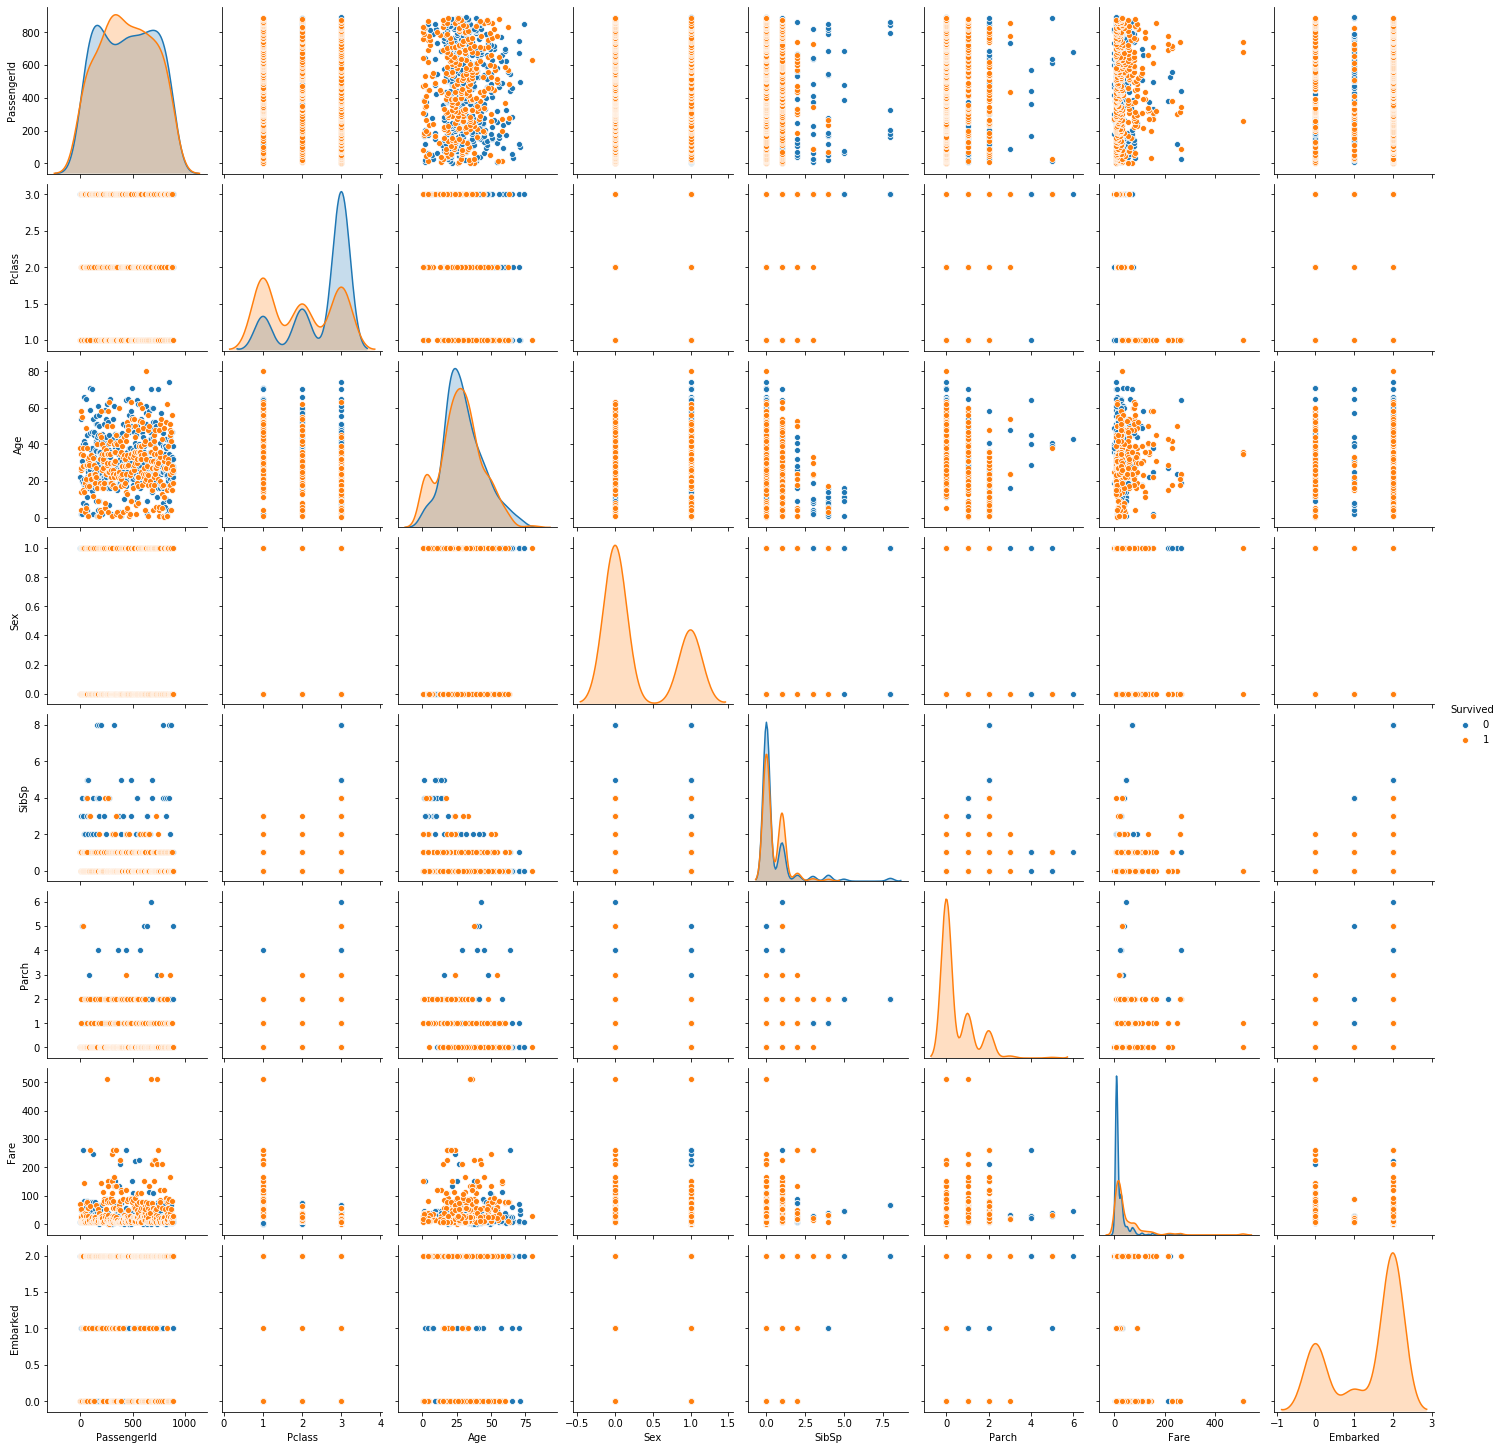

In [25]:
# 対散布図
df_tmp_plot = df_tmp[["PassengerId", "Survived", "Pclass", "Age", "Sex", "SibSp", "Parch", "Fare", "Embarked"]]
sns.pairplot(df_tmp_plot, hue="Survived")
plt.show()

* sibsp, parchが大きい人で生き残ってる人が少ない？
* pclassがいい人（金持ち）は生き残りやすい
* fareが低い人（≒pclassが悪い人？）は生き残れない
* 女性の方が生き残ってる
* 若い人が生き残ってる
* Embarked（乗った場所）はSの人が生き残ってる（そもそもSで乗る人がおおいだけ？）

## feature engineering

In [20]:
df_tmp["family_size"] = df_tmp["SibSp"] + df_tmp["Parch"] + 1
df_tmp["is_alone"] = 0
df_tmp["is_alone"] = df_tmp["is_alone"].mask(df_tmp["family_size"] == 1, 1)
df_tmp["title"] = df_tmp["Name"].str.extract("([A-Za-z]+)\.", expand=False)
df_tmp['title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col',
                         'Rev','Capt','Sir','Don'], ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)
df_tmp.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,same_ticket,ticket_1,family_size,is_alone,title
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,2,1,A,2,0,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0,1,P,2,0,Mrs
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,2,1,S,1,1,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,2,1,2,0,Mrs
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,2,1,3,1,1,Mr


In [21]:
set(df_tmp["title"])

{'Master', 'Miss', 'Mr', 'Mrs', 'Other'}

In [22]:
df_tmp.loc[(df_tmp.Age.isnull())&(df_tmp.title=='Mr'),'Age'] = df_tmp.Age[df_tmp.title=="Mr"].mean()
df_tmp.loc[(df_tmp.Age.isnull())&(df_tmp.title=='Mrs'),'Age'] = df_tmp.Age[df_tmp.title=="Mrs"].mean()
df_tmp.loc[(df_tmp.Age.isnull())&(df_tmp.title=='Master'),'Age'] = df_tmp.Age[df_tmp.title=="Master"].mean()
df_tmp.loc[(df_tmp.Age.isnull())&(df_tmp.title=='Miss'),'Age'] = df_tmp.Age[df_tmp.title=="Miss"].mean()
df_tmp.loc[(df_tmp.Age.isnull())&(df_tmp.title=='Other'),'Age'] = df_tmp.Age[df_tmp.title=="Other"].mean()

In [23]:
df_tmp.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,same_ticket,ticket_1,family_size,is_alone,title
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,2,1,A,2,0,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0,1,P,2,0,Mrs
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,2,1,S,1,1,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,2,1,2,0,Mrs
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,2,1,3,1,1,Mr


In [24]:
df_tmp = df_tmp.drop(["Name", "Ticket"], axis=1)
df_tmp.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,same_ticket,ticket_1,family_size,is_alone,title
0,0,3,1,22.0,1,0,7.2500,2,1,A,2,0,Mr
1,1,1,0,38.0,1,0,71.2833,0,1,P,2,0,Mrs
2,1,3,0,26.0,0,0,7.9250,2,1,S,1,1,Miss
3,1,1,0,35.0,1,0,53.1000,2,2,1,2,0,Mrs
4,0,3,1,35.0,0,0,8.0500,2,1,3,1,1,Mr


In [25]:
# lightgbmは数値かbooleanしかダメなのでlabel encodingが必要
for column in ["ticket_1", "title"]:
    target_column = df_tmp[column]
    le = LabelEncoder()
    le.fit(target_column)
    # df_tmp[column] = le.transform(target_column)
    label_encoded_column = le.transform(target_column)
    df_tmp[column] = pd.Series(label_encoded_column).astype('category')

df_tmp.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,same_ticket,ticket_1,family_size,is_alone,title
0,0,3,1,22.0,1,0,7.2500,2,1,4,2,0,2
1,1,1,0,38.0,1,0,71.2833,0,1,7,2,0,3
2,1,3,0,26.0,0,0,7.9250,2,1,8,1,1,1
3,1,1,0,35.0,1,0,53.1000,2,2,0,2,0,3
4,0,3,1,35.0,0,0,8.0500,2,1,2,1,1,2


## modeling

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop("Survived", axis=1), df_tmp["Survived"])

In [27]:
trains = lgb.Dataset(X_train, label=y_train)
valids = lgb.Dataset(X_test, label=y_test, reference=trains)

In [32]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss'
}

best_params, history = {}, []

model = lgb.train(params, trains, valid_sets=valids,
                    verbose_eval=False,
                    num_boost_round=1000,
                    early_stopping_rounds=20,
                    best_params=best_params,
                    tuning_history=history)

C:\Users\y0shi\anaconda3\envs\py37dev\lib\site-packages\optuna\_experimental.py:90: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning,
min_data_in_leaf, val_score: 0.421763: 100%|#############################################| 5/5 [00:01<00:00,  4.43it/s]


In [33]:
best_params

{'lambda_l1': 0.0038604467013963533,
 'lambda_l2': 0.0030249159994645775,
 'num_leaves': 26,
 'feature_fraction': 0.7,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'objective': 'binary',
 'metric': 'binary_logloss'}

In [34]:
model.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('binary_logloss', 0.4217628065291738)])})

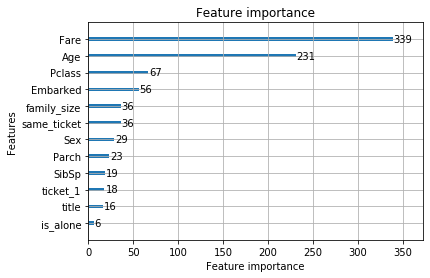

In [35]:
# 特徴量の重要度をプロット
lgb.plot_importance(model)

## 予測

In [37]:
# 読み込み
df_test = pd.read_csv("./data/test.csv")
passenger_id = df_test["PassengerId"]
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [38]:
df_test.describe(include="all")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Nasr, Mr. Mustafa",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [ ]:
# Fareに欠損があるので埋める

In [79]:
# テストデータの処理
df_test["ticket_1"] = df_test["Ticket"].str[:1]
df_test["ticket_1"] = df_test["ticket_1"].apply(lambda x: "4" if re.match("[4-9]", x) else x)

# 性別を数値に置き換え
# male: 1, female: 0
df_test = df_test.replace("male", 1).replace("female", 0)

# Embarkedを数値に置き換え
# C: 0, Q: 1, S: 2
df_test["Embarked"] = df_test["Embarked"].replace("C", 0).replace("Q", 1).replace("S", 2)

df_test["family_size"] = df_test["SibSp"] + df_test["Parch"] + 1
df_test["is_alone"] = 0
df_test["is_alone"] = df_test["is_alone"].mask(df_test["family_size"] == 1, 1)
df_test["title"] = df_test["Name"].str.extract("([A-Za-z]+)\.", expand=False)
df_test['title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col',
                         'Rev','Capt','Sir','Don', 'Master'], ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test.loc[(df_test.Age.isnull())&(df_test.title=='Mr'),'Age']= df_test.Age[df_test.title=="Mr"].mean()
df_test.loc[(df_test.Age.isnull())&(df_test.title=='Mrs'),'Age']= df_test.Age[df_test.title=="Mrs"].mean()
#df_test.loc[(df_test.Age.isnull())&(df_test.title=='Master'),'Age']= df_test.Age[df_test.title=="Master"].mean()
df_test.loc[(df_test.Age.isnull())&(df_test.title=='Miss'),'Age']= df_test.Age[df_test.title=="Miss"].mean()
df_test.loc[(df_test.Age.isnull())&(df_test.title=='Other'),'Age']= df_test.Age[df_test.title=="Other"].mean()

df_test = df_test.drop(["Name", "PassengerId", "Cabin", "Ticket"], axis=1)

# lightgbmは数値かbooleanしかダメなのでlabel encodingが必要
for column in ["ticket_1", "title"]:
    target_column = df_test[column]
    le = LabelEncoder()
    le.fit(target_column)
    # df_test[column] = le.transform(target_column)
    label_encoded_column = le.transform(target_column)
    df_test[column] = pd.Series(label_encoded_column).astype('category')

df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,ticket_1,family_size,is_alone,title
0,3,1,34.5,0,0,7.8292,1,2,1,1,2
1,3,0,47.0,1,0,7.0000,2,2,2,0,3
2,2,1,62.0,0,0,9.6875,1,1,1,1,2
3,3,1,27.0,0,0,8.6625,2,2,1,1,2
4,3,0,22.0,1,1,12.2875,2,2,3,0,3


In [74]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    int64   
 1   Pclass       891 non-null    int64   
 2   Sex          891 non-null    int64   
 3   Age          891 non-null    float64 
 4   SibSp        891 non-null    int64   
 5   Parch        891 non-null    int64   
 6   Fare         891 non-null    float64 
 7   Embarked     889 non-null    float64 
 8   ticket_1     891 non-null    category
 9   family_size  891 non-null    int64   
 10  is_alone     891 non-null    int64   
 11  title        891 non-null    category
dtypes: category(2), float64(3), int64(7)
memory usage: 72.1 KB


In [75]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Pclass       418 non-null    int64   
 1   Sex          418 non-null    int64   
 2   Age          418 non-null    float64 
 3   SibSp        418 non-null    int64   
 4   Parch        418 non-null    int64   
 5   Fare         417 non-null    float64 
 6   Embarked     418 non-null    int64   
 7   ticket_1     418 non-null    category
 8   family_size  418 non-null    int64   
 9   is_alone     418 non-null    int64   
 10  title        418 non-null    category
dtypes: category(2), float64(2), int64(7)
memory usage: 30.9 KB


In [85]:
# テストデータを予測する
y_pred = model.predict(df_test, num_iteration=model.best_iteration)
y_pred = [0 if i < 0.5 else 1 for i in y_pred]

In [86]:
output = pd.concat([passenger_id, pd.Series(y_pred, name="Survived")], axis=1)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [87]:
output.to_csv("./output.csv", index=False)